# ADA - Homework 4

In [1]:
#Usefull imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model, datasets, feature_extraction, model_selection, ensemble
import networkx as nx

## Question 1
#### Dataset description
Here are the columns of the dataset and which values they can take
- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)


### 1. A naive analysis

In [2]:
#loading the data
data = pd.DataFrame.from_csv('lalonde.csv')
data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
#creation of two dataframes: on for treated subjects and another one for non-treated subjects
not_treat = data[data['treat'] == 0]
treat = data[data['treat'] == 1]
print('Number of untreated persons : ', len(not_treat))
print('Number of treated persons : ', len(treat))

Number of untreated persons :  429
Number of treated persons :  185


The first thing that we should notice is that there is more than twice non participants than participants so we should keep in mind to normalize the results.

In [4]:
#We create a dictionnary that return an appropriate name given a column label
#This will be useful for the plot titles and axis labels
cat_to_name = {
    'treat' : 'Participation or not in training',
    'age' : 'Age',
    'educ' :'Years of education',
    'race' : 'Race',
    'married' : 'Married or not',
    'nodegree' : 'Absence of degree or not',
    're74': 'Income in 1974',
    're75' : 'Income in 1975',
    're78' : 'Income in 1978'
}

In [5]:
#function creating two bar charts for two dataframes and the same specified category
#We force the charts to have the same values for both axis, to help comparison
def plot_barchart(not_treat_df, treat_df, cat, bins_range, yticks_range):
    #Retrieve nice name for the column label
    cat_name = cat_to_name[cat]
    fig = plt.figure()
    fig.set_size_inches(12, 5)
    #Plot the untreated category
    plt.subplot(121)
    hist1, bin_edges = np.histogram(not_treat_df[cat], bins_range)
    #Compute the width of the bar in order to see them on graph, multiply by 0.9 to differentiate
    #bars easily
    w = (bin_edges[1] - bin_edges[0])*0.9
    plt.bar(bin_edges[:-1], 100*hist1/np.sum(hist1), width = w, align='edge')
    #We draw grids to help comparison
    plt.gca().grid()
    plt.gca().set_yticks(yticks_range)
    plt.xlabel(cat_name)
    plt.ylabel('Number of non participants (in %)')
    plt.title('Repartition of ' + cat_name+ ' of non participants')

    plt.subplot(122)
    hist2, bin_edges = np.histogram(treat_df[cat], bins_range)
    w = (bin_edges[1] - bin_edges[0])*0.9
    plt.bar(bin_edges[:-1], 100*hist2/np.sum(hist2), width = w, align='edge')
    plt.gca().grid()
    plt.gca().set_yticks(yticks_range)
    plt.xlabel(cat_name)
    plt.ylabel('Number of participants (in %)')
    plt.title('Repartition of ' + cat_name+ ' of participants')

    plt.show()

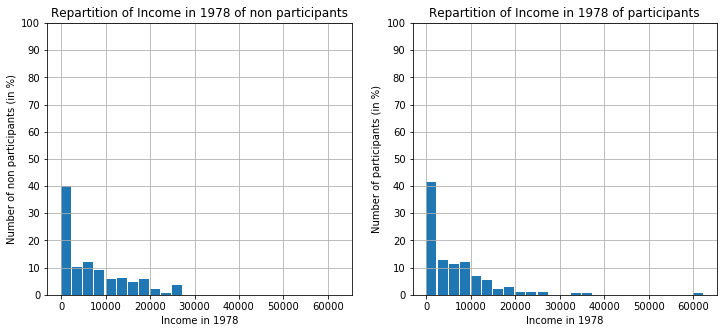

In [6]:
bins_range = range(0, 65000, 2500)
plot_barchart(not_treat, treat, 're78', bins_range, range(0, 105, 10))

From this analysis one could easily think that the training does not improve the incomes.

In [7]:
#function creating box plots for two dataframes and the same specified category
def plot_box(not_treat_df, treat_df, cat, yticks_range):
    #Retrieve nice name of cat to display on title and label
    cat_name = cat_to_name[cat]
    fig= plt.figure()
    fig.set_size_inches(12,5)

    plt.subplot(121)
    plt.boxplot(not_treat_df[cat])
    ax = plt.gca().yaxis
    ax.grid(True)
    plt.title('Distribution of '+cat_name+' in non participants')
    plt.xticks([1], [cat_name])
    plt.yticks(yticks_range)
    
    
    plt.subplot(122)
    plt.boxplot(treat_df[cat])
    ax = plt.gca().yaxis
    ax.grid(True)
    plt.title('Distribution of '+cat_name+' in participants')
    plt.xticks([1], [cat_name])
    plt.yticks(yticks_range)
    
    plt.show()

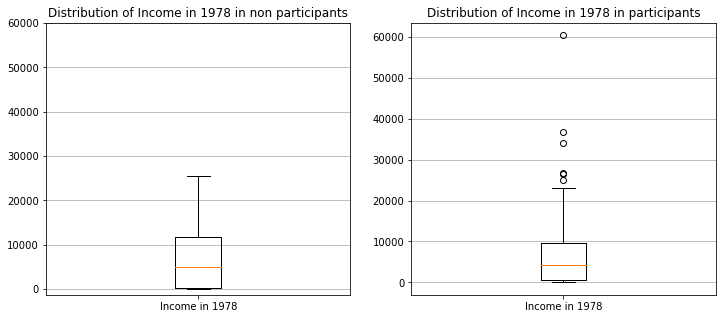

In [8]:
plot_box(not_treat, treat, 're78', range(0, 65000, 10000))

In [9]:
print('Median Income (1978) of untreated persons : ', not_treat['re78'].median())

Median Income (1978) of untreated persons :  4975.505


In [10]:
print('Median Income (1978) of treated persons : ', treat['re78'].median())

Median Income (1978) of treated persons :  4232.309


With this visualisation we could conclude that the training increased a lot the income of the best students. Though the medians are not very different.

### 2. A closer look at the data

We will plot the data for all categories and analyse afterwards

#### Age

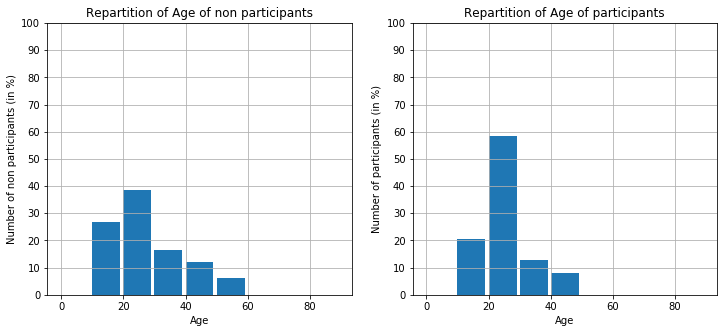

In [11]:
plot_barchart(not_treat, treat, 'age', bins_range = range(0, 100, 10), 
                                                yticks_range = range(0, 105, 10))

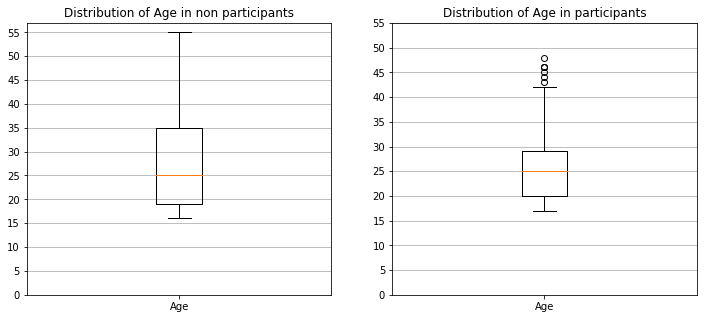

In [12]:
plot_box(not_treat, treat,'age', range(0, 60, 5))

#### Educ

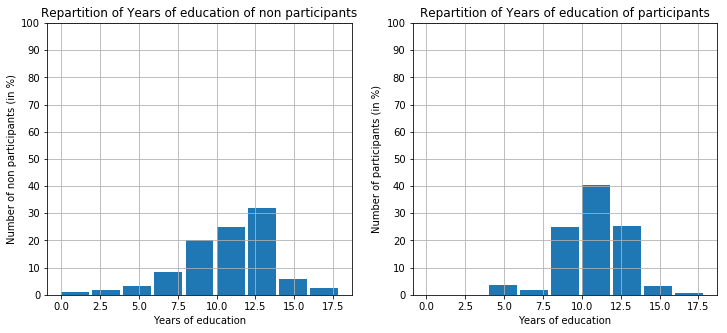

In [13]:
plot_barchart(not_treat, treat,'educ', bins_range = range(0, 20, 2), 
                                                yticks_range = range(0, 105, 10))

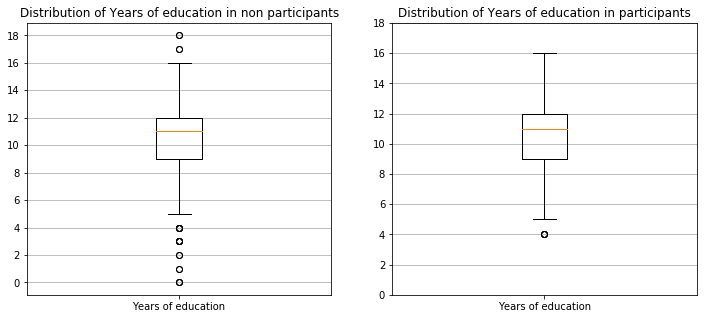

In [14]:
plot_box(not_treat, treat,'educ', range(0, 20, 2))

#### Race

In [15]:
#returns a dictionary with the numbers of subjects in df regarding their 'race' values
def get_repartition_race(df):
    res = {'black' : 0, 'hispanic':0, 'white':0}
    res['black'] = len(df[df['black'] == 1])
    res['hispanic'] = len(df[df['hispan'] == 1])
    #We guess that 'white' is when 'black' == 0 and 'hispanic' == 0
    res['white'] = len(df) - res['black'] - res['hispanic']
    return res

In [16]:
#plot two pie plots for two dataframes regarding their race attributes
def plot_race_pie(not_treat, treat):
    not_treat_race = get_repartition_race(not_treat)
    treat_race = get_repartition_race(treat)

    fig = plt.figure()
    fig.set_size_inches(12,5)

    plt.subplot(121)
    plt.pie(list(not_treat_race.values()), autopct='%1.1f%%', labels = not_treat_race.keys())
    plt.title('Percentages of non participants per category')

    plt.subplot(122)
    plt.pie(list(treat_race.values()), autopct='%1.1f%%', labels =treat_race.keys())
    plt.title('Percentages of participants per category')

    plt.show()

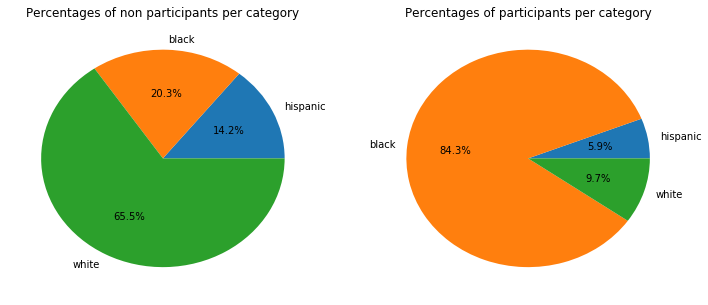

In [17]:
plot_race_pie(not_treat, treat)

#### Married

In [18]:
not_treat_married = len(not_treat[not_treat['married'] == 1])
print('The proportion of married people in the non participants is ', np.round(not_treat_married/len(not_treat),2)*100, '%')

treat_married = len(treat[treat['married'] == 1])
print('The proportion of married people in the participants is ', np.round(treat_married/len(treat),2)*100, '%')

The proportion of married people in the non participants is  51.0 %
The proportion of married people in the participants is  19.0 %


#### Nodegree

In [19]:
not_treat_nodegree = len(not_treat[not_treat['nodegree'] == 1])
print('The proportion of people without any degree in the non participants is ', np.round(not_treat_nodegree/len(not_treat),2)*100, '%')

treat_nodegree = len(treat[treat['nodegree'] == 1])
print('The proportion of people without any degree in the participants is ', np.round(treat_nodegree/len(treat),2)*100, '%')

The proportion of people without any degree in the non participants is  60.0 %
The proportion of people without any degree in the participants is  71.0 %


#### Re74

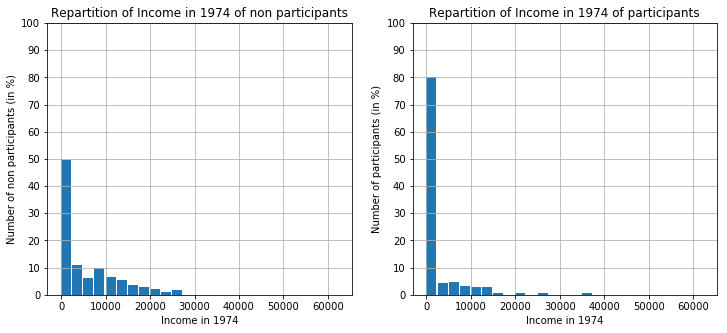

In [20]:
plot_barchart(not_treat, treat,'re74', bins_range = range(0, 65000, 2500), 
                                                yticks_range = range(0, 105, 10))

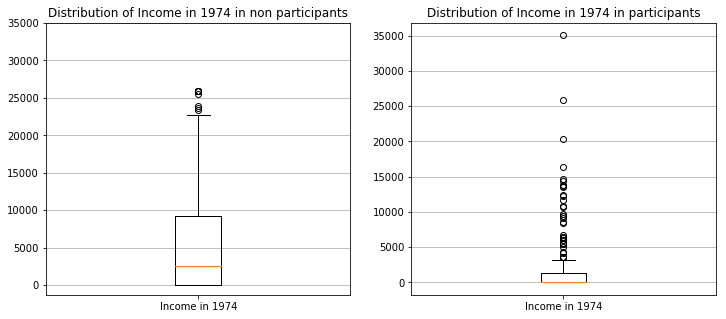

In [21]:
plot_box(not_treat, treat,'re74', range(0, 40000, 5000))

#### Re75

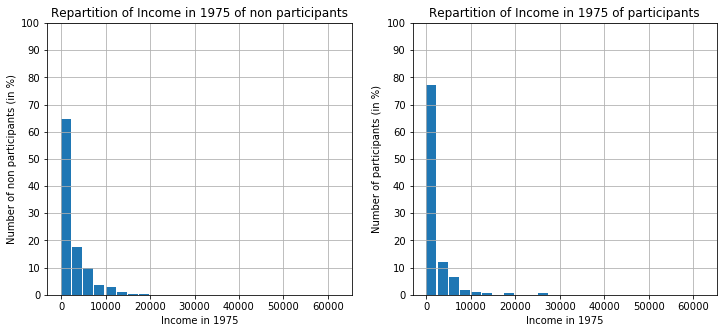

In [22]:
plot_barchart(not_treat, treat,'re75', bins_range = range(0, 65000, 2500), 
                                                yticks_range = range(0, 105, 10))

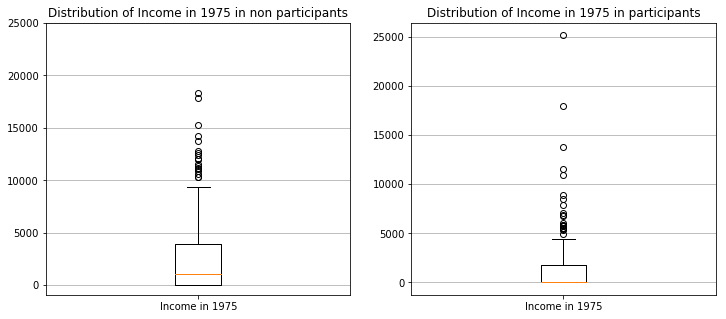

In [23]:
plot_box(not_treat, treat,'re75', range(0, 30000, 5000))

**Analysis:**

Recall that the naive analysis makes it looks like doing the training does not increase your salary. In this analysis we point out some elements that could explain such result.

Begining with the age of the subjects, we observe that 80% of the treated subjects are younger than 30 years old, for "only" 64% of the not-treated group under 30 years old. Hence the treated group is much younger than the control one, and it seems normal that older employees are generally better paid for their ancestory or because they now have a better position than the younger employees.

Following in this direction, we observe that 70% of the treated employees don't have a degree, against 60% in the not treated group. This also can explain the highest salary for non-treated subjects: positions requiring a degree have better salaries.
Now if we look at the graduated employees, we see that more than 70% of the non-treated employees have 10 or more years of education, whereas less than 60% of the treated employees are in the same situation. As before, jobs with higher education requirements are better paid.

Looking at the "race" of the employees, we observe that, where only 35% of the non-treatedd employees are not "white", 80% of the treated employees are "black". Regarding the fact that these data are concerning US population during the 70s, and even if the racial segregation period ended in 1968 in the USA, we can still say that segregationist behaviors could be at the origin of smaller salaries for afro-americans, and so for the treated group of our data.

We also get a huge difference for the proportion of married people in the groups: more than 50% are married in the non-treated group, against only 19% in the other group.

The revenue of 74 and 75 shows that a very large proportion of the treated-group had a null salary, against nearly a half of the not treated group. This can explain why we find less high salaries in the treated group in 78, compared to the non-treated group.

Hence we see that the contextual data, aside for the 78 revenue, make the naive analysis completly different.

### 3. A propensity score model

We recall the definition of propensity score according to lecture 5 : $e(x) = Pr(Z = 1 | x)$ <br>
So we will predict the probability of a person to belong to the treated group with a LogisiticRegression approach. We will use the scikit library for this step.

You can access documentation here : http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score

In [24]:
logistic = linear_model.LogisticRegression()

In [25]:
#Get rid of 'treat' column (index 0) and 're78' (index 9)
#'treat' is the label vector and 're78' is directly impacted by the label
cols = data.columns[1:9] 
print(cols)
#We train the model
logistic.fit(X= data[cols], y = data['treat'])

Index(['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74',
       're75'],
      dtype='object')


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [26]:
#We predict thanks to the model the probabilities of each person to belong 
#to each of the 2 labels
scores = logistic.predict_proba(X = data[cols])
#To know which column is for 'treat' = 1, we query the classes attribute of the model
#as the columns of scores are in the same order
print(logistic.classes_)
#We can see that the propensity scores are the second column (as we want label 1)
#We perform a quick check, as we know the 5 first have 'treat' = 1
#let's compare the probabilitiies
scores[:5, :]
#It should indeed be the second column

[0 1]


array([[ 0.55664958,  0.44335042],
       [ 0.85534047,  0.14465953],
       [ 0.27764537,  0.72235463],
       [ 0.33584948,  0.66415052],
       [ 0.30171439,  0.69828561]])

In [27]:
#We create a dictionary that given an id return the propensity score
propensity = {}
for i, idx in enumerate(data.index):
    propensity[idx] = scores[i, 1]

In [28]:
#Here is an example
propensity['NSW3']

0.7223546326678244

### 4. Balancing the dataset via matching
In order to get the matching according to propensity score, we will construct a graph. <br>
In this graph we will have a node per dataframe id (person). <br>
Every person from the not_treated group will have an edge to every person of the treated_group. Every edge will have the following weight : $- |  propensity\_score[not\_treated] - propensity\_score[treated] |$ <br>
We take the absolute value of the difference in propensity scores and we want to minimize the sum of those weights.
As the matching function of Networkx computes the maximum weight, we added the minus sign to get the minimum weight matching. <br>

Networkx max_weight_matching doc : https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.matching.max_weight_matching.html#networkx.algorithms.matching.max_weight_matching

In [29]:
G = nx.Graph()
G.add_nodes_from(data.index)
#We create an edge from every not-treated subject to every treated
for not_treated in not_treat.index:
    for treated in treat.index:
        #We compute the weight
        w = - np.absolute(propensity[not_treated] - propensity[treated])
        G.add_edge(not_treated, treated, weight = w)

In [30]:
#Compute the matching that minimize the sum of all absolute difference of propensity scores
mate = nx.max_weight_matching(G, maxcardinality=True)

In [31]:
#Here is an example of the matching
mate['NSW1']

'PSID281'

In [32]:
#Extract the ids of the 2 sub-groups created through the matching
not_treat_subgroup = [x for x in mate.keys() if x.startswith('PSID')]
treat_subgroup = [y for y in mate.keys() if y.startswith('NSW')]
#Compute the sub-dataframes according to the sub-groups
not_treat_subdf = not_treat.loc[not_treat_subgroup]
treat_subdf = treat.loc[treat_subgroup]

We will apply the same functions to visualize the results and analyze them

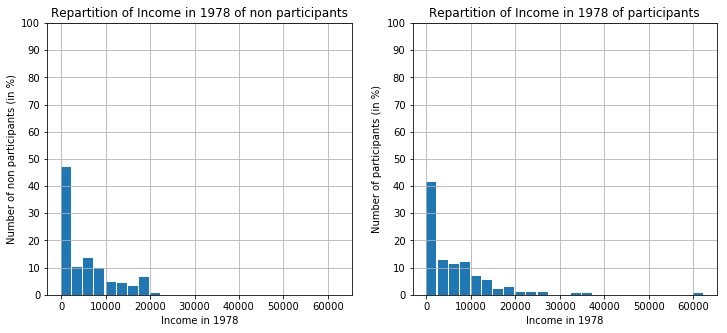

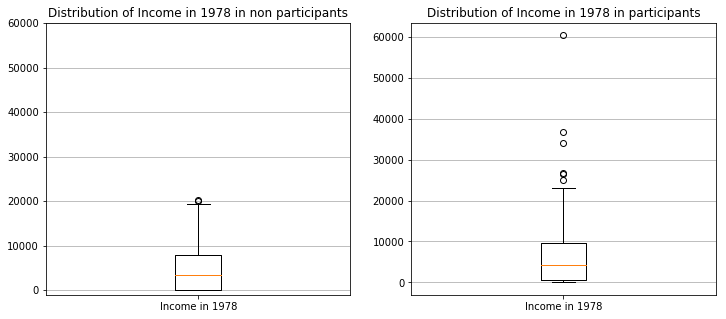

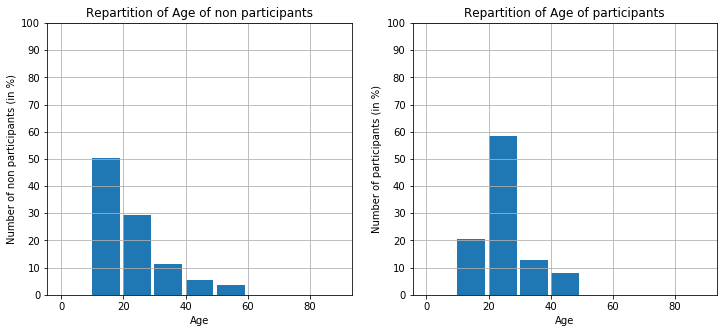

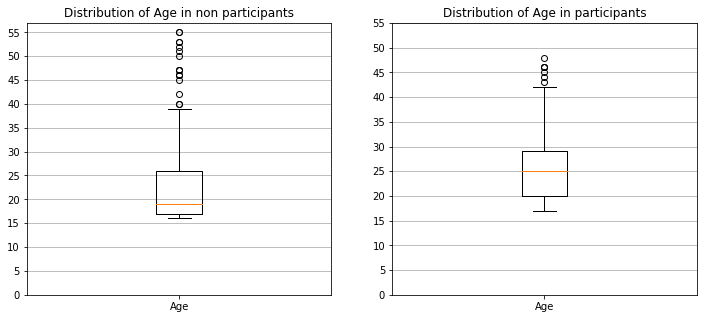

The proportion of people without any degree in the non participants is  62.7 %
The proportion of people without any degree in the participants is  70.81 %


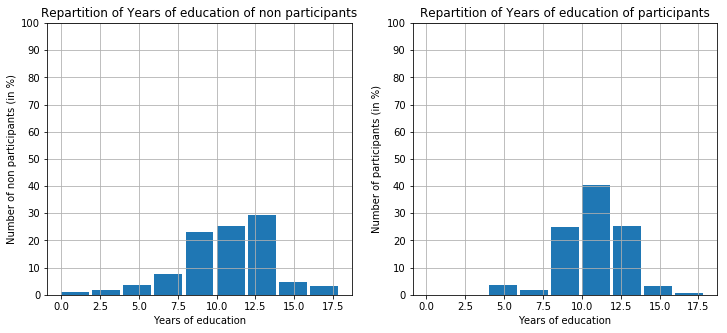

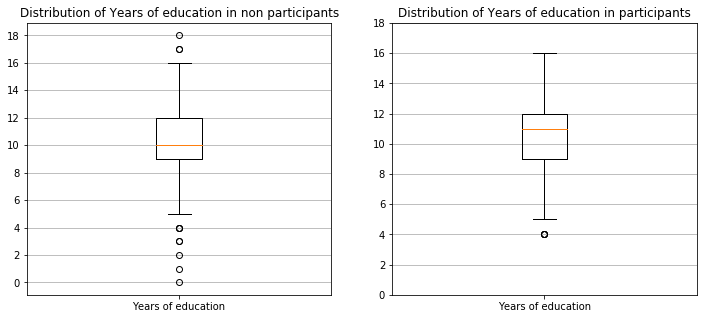

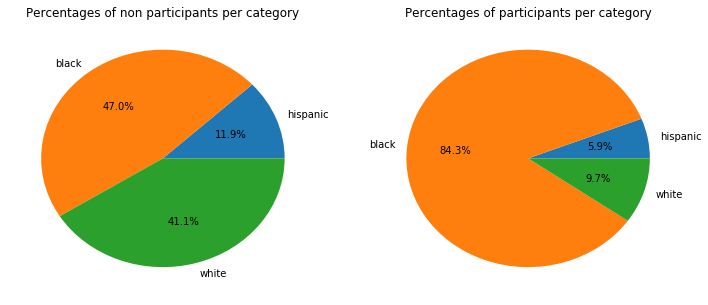

The proportion of married people in the non participants is  17.0 %
The proportion of married people in the participants is  19.0 %


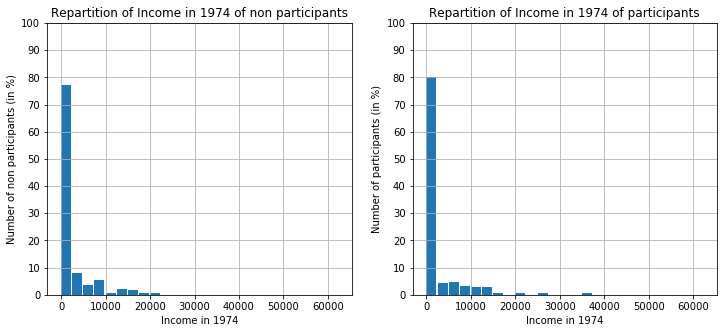

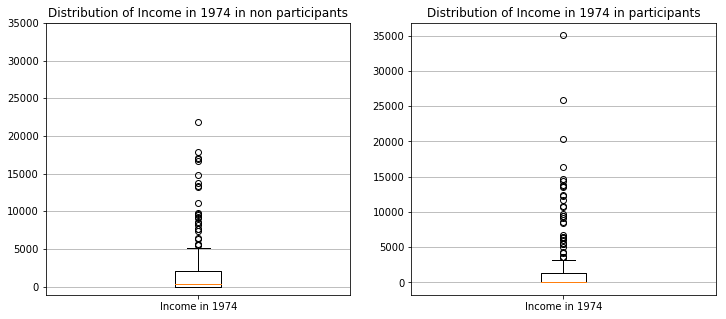

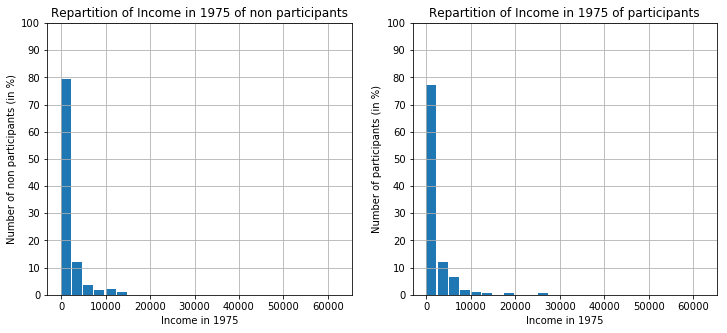

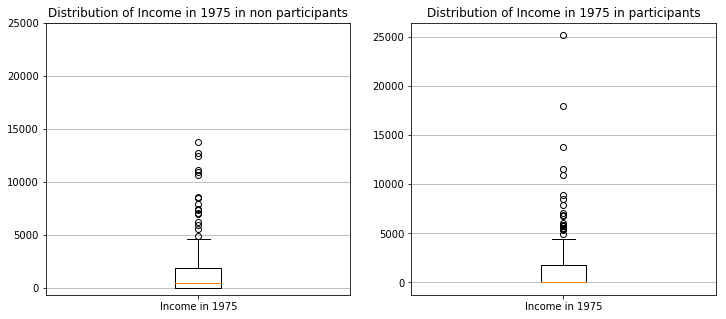

In [33]:
plot_barchart(not_treat_subdf, treat_subdf, 're78', range(0, 65000, 2500), range(0, 105, 10))

plot_box(not_treat_subdf, treat_subdf, 're78', range(0, 65000, 10000))

plot_barchart(not_treat_subdf, treat_subdf, 'age', bins_range = range(0, 100, 10), 
                                                yticks_range = range(0, 105, 10))

plot_box(not_treat_subdf, treat_subdf,'age', range(0, 60, 5))

not_treat_subdf_nodegree = len(not_treat_subdf[not_treat_subdf['nodegree'] == 1])
print('The proportion of people without any degree in the non participants is ', np.round(100*not_treat_subdf_nodegree/len(not_treat_subdf),2), '%')

treat_subdf_nodegree = len(treat_subdf[treat_subdf['nodegree'] == 1])
print('The proportion of people without any degree in the participants is ', np.round(100*treat_subdf_nodegree/len(treat_subdf),2), '%')

plot_barchart(not_treat_subdf, treat_subdf,'educ', bins_range = range(0, 20, 2), 
                                                yticks_range = range(0, 105, 10))

plot_box(not_treat_subdf, treat_subdf,'educ', range(0, 20, 2))

plot_race_pie(not_treat_subdf, treat_subdf)

not_treat_subdf_married = len(not_treat_subdf[not_treat_subdf['married'] == 1])
print('The proportion of married people in the non participants is ', np.round(not_treat_subdf_married/len(not_treat_subdf),2)*100, '%')

treat_subdf_married = len(treat_subdf[treat_subdf['married'] == 1])
print('The proportion of married people in the participants is ', np.round(treat_subdf_married/len(treat_subdf),2)*100, '%')


plot_barchart(not_treat_subdf, treat_subdf,'re74', bins_range = range(0, 65000, 2500), 
                                                yticks_range = range(0, 105, 10))

plot_box(not_treat_subdf, treat_subdf,'re74', range(0, 40000, 5000))

plot_barchart(not_treat_subdf, treat_subdf,'re75', bins_range = range(0, 65000, 2500), 
                                                yticks_range = range(0, 105, 10))

plot_box(not_treat_subdf, treat_subdf,'re75', range(0, 30000, 5000))

**Analysis** :

Comparing the two groups on their 78 revenue, we see that more non-treated subjects (~45%) have a null revenue than the treated subjects (~40%). Moreover, where 1% of the non-treated have a revenue superior to 20.000, more than 6% of the treated group have a revenue between 20.000 and 60.000.
The distribution between 0 and 20.000 is pretty normal in both groups, but one can note that the median in the treated group is higher than in the control group (4230$ against 3400$), and as the median is resistant to outliers, it is not that much impacted by the revenues superior to 20.000$. These previous observations allow us to conclude on few points:
 
 More treated subjects have found a job (if we compre the revenues of 74 and 75 it's pretty obvious), it's easier for them to get positions with high revenues (>20.000) and they generaly are better paid than non-treated subjects.
 
 We now compare the different distributions for the matched subjects.
 
 For the age distribution, we get roughly 80% of the subjects in both groups under 30 years old, and distribution is quite the same, except for 4% of the non-treated group which is between 50 and 60 years old.
 
The number of subjects without a degree naturally didn't change much (a bit more of the treated subjects are concerned) but all of the treated subjects have at least a 4 years education, and their median pushes to 11 years against 10 years for the non-treated subjects. 

If the proportion of black people in the treated group is still roughly 80%, we get a better distribution in the non-treated group with roughly 40% of whites, 10% of hispanic subjects and 50% of black ones.

The distribution of married people is pretty even with 17% of non-treated and 19% of treated subjects married.

Finally, the distributions of the revenues in 74 and 75 are very similar for both groups.

We see with this new analysis that the ontext of the data is now less impactful and so our results in 78 make more sense.

### 5. Balancing the groups further

We are looking for a feature which is hard to balance and that is impacting our results in a hard way. 

Talking about hard balance, the age crieria comes to mind quite quickly: it is difficult for us to balance both groups since the non-treated group contains older subjects since the job formation was organised first and foremost for young subjects.

However the most important and impactful criteria is the 'race' one. First of all, we have seen in **2.** that the racial distribution is very different in both groups, and that the previous matching only reduces this huge difference without making them disappear. Secondly, as discussed in **2.**, the racial trait can be considered as one fo the most impactful criteria due to the racial segregation historic of the USA during the 70s. A race different mainly from white/hispanic to black can easily be at the origin of lower revenues, lower education level, degree acquisition and even unemployement (0$ revenue).

That's why we decide to match the subjects according to their race and age in priority. <br>
Hence we will create an edge between 2 persons only if they have a similar age and the same "race".

In [34]:
G = nx.Graph()
G.add_nodes_from(data.index)

for i, not_treated in not_treat.iterrows():
    for j, treated in treat.iterrows():
        #Compute boolean conditions to check before creating an edge
        hispan = (treated['hispan'] == 1 and not_treated['hispan'] == 1)
        black = (treated['black'] == 1 and not_treated['black'] == 1)
        white = (treated['hispan'] == 0 and not_treated['hispan'] == 0 and treated['black'] == 0 and not_treated['black'] == 0)
        same_race = hispan or black or white
        age_difference = np.abs(not_treated['age'] - treated['age'])
        if same_race and age_difference <=3:
            w = - np.absolute((propensity[i] - propensity[j]))
            G.add_edge(i, j, weight = w)

In [35]:
better_mate = nx.max_weight_matching(G, maxcardinality=True)

In [36]:
not_treat_group_new = [x for x in better_mate.keys() if x.startswith('PSID')]
treat_group_new = [y for y in better_mate.keys() if y.startswith('NSW')]
not_treat_newdf = not_treat.loc[not_treat_group_new]
treat_newdf = treat.loc[treat_group_new]

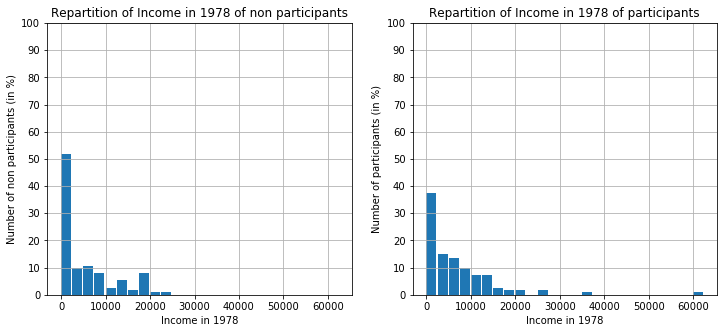

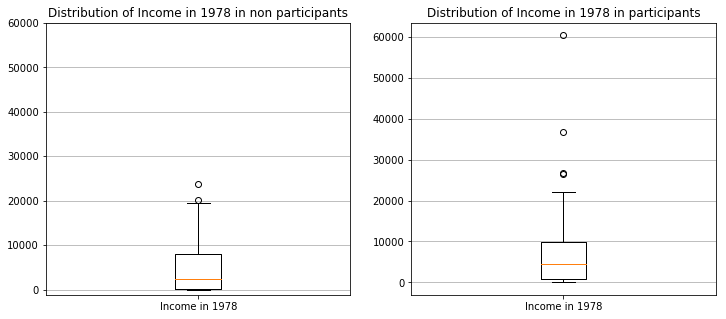

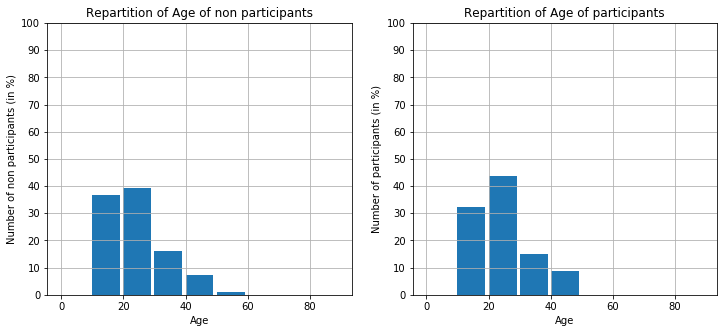

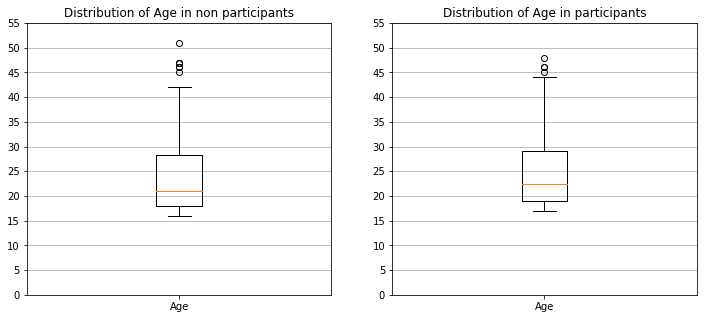

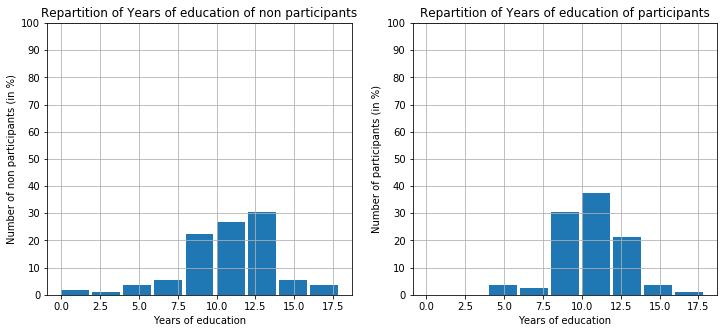

The proportion of people without any degree in the non participants is  61.0 %
The proportion of people without any degree in the participants is  74.0 %


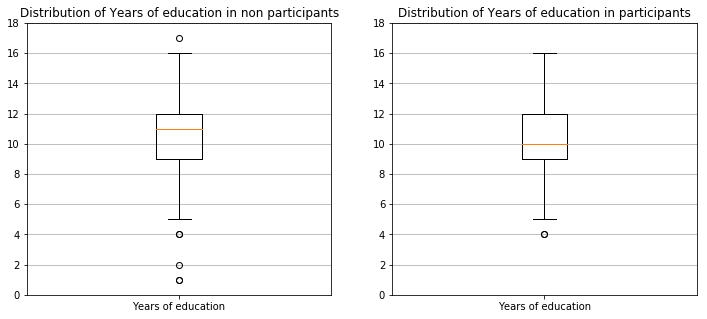

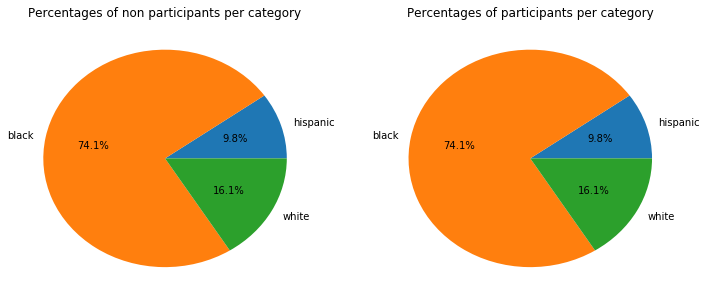

The proportion of married people in the non participants is  26.0 %
The proportion of married people in the participants is  24.0 %


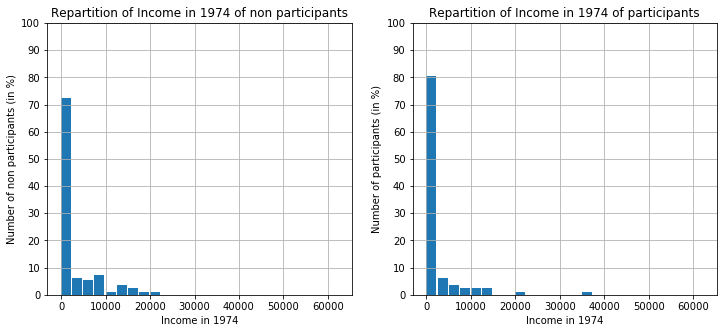

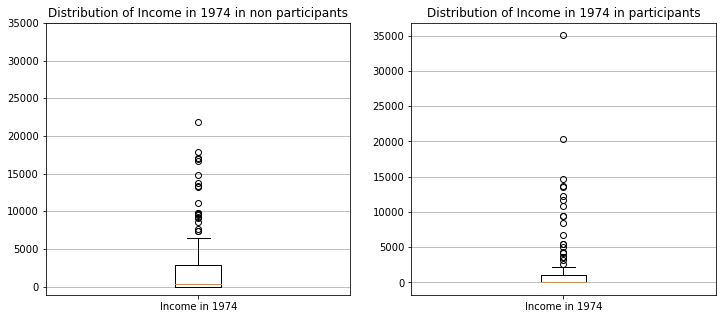

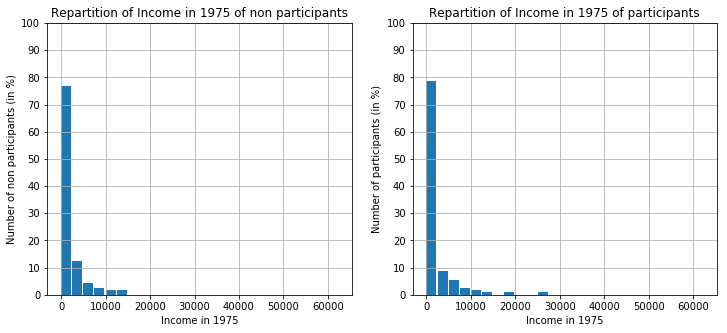

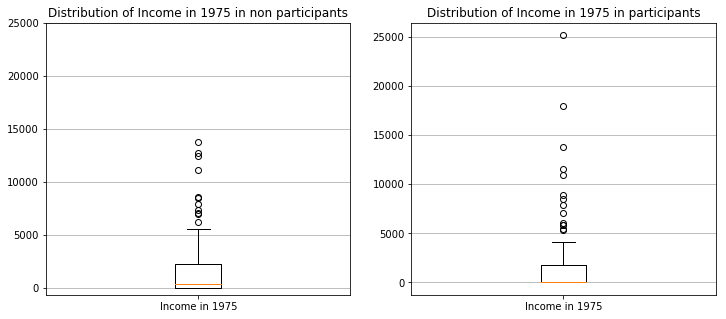

In [37]:
plot_barchart(not_treat_newdf, treat_newdf, 're78', range(0, 65000, 2500), range(0, 105, 10))

plot_box(not_treat_newdf, treat_newdf, 're78', range(0, 65000, 10000))

plot_barchart(not_treat_newdf, treat_newdf, 'age', bins_range = range(0, 100, 10), 
                                                yticks_range = range(0, 105, 10))

plot_box(not_treat_newdf, treat_newdf,'age', range(0, 60, 5))

plot_barchart(not_treat_newdf, treat_newdf,'educ', bins_range = range(0, 20, 2), 
                                                yticks_range = range(0, 105, 10))

not_treat_newdf_nodegree = len(not_treat_newdf[not_treat_newdf['nodegree'] == 1])
print('The proportion of people without any degree in the non participants is ', 
      np.round(not_treat_newdf_nodegree/len(not_treat_newdf),2)*100, '%')

treat_newdf_nodegree = len(treat_newdf[treat_newdf['nodegree'] == 1])
print('The proportion of people without any degree in the participants is ', 
      np.round(treat_newdf_nodegree/len(treat_newdf),2)*100 , '%')

plot_box(not_treat_newdf, treat_newdf,'educ', range(0, 20, 2))

plot_race_pie(not_treat_newdf, treat_newdf)

not_treat_newdf_married = len(not_treat_newdf[not_treat_newdf['married'] == 1])
print('The proportion of married people in the non participants is ', 
      np.round(not_treat_newdf_married/len(not_treat_newdf),2)*100, '%')

treat_newdf_married = len(treat_newdf[treat_newdf['married'] == 1])
print('The proportion of married people in the participants is ', 
      np.round(treat_newdf_married/len(treat_newdf),2)*100, '%')

plot_barchart(not_treat_newdf, treat_newdf,'re74', bins_range = range(0, 65000, 2500), 
                                                yticks_range = range(0, 105, 10))

plot_box(not_treat_newdf, treat_newdf,'re74', range(0, 40000, 5000))

plot_barchart(not_treat_newdf, treat_newdf,'re75', bins_range = range(0, 65000, 2500), 
                                                yticks_range = range(0, 105, 10))

plot_box(not_treat_newdf, treat_newdf,'re75', range(0, 30000, 5000))

### 6. A less naive analysis

As expected from our new matching, we get the same racial distribution in both groups, and the age distribution is similar enough to loose its previous impact. The married proportions are very close (26% and 24%) and can be considered impactless at this point.

Now, looking at the educations statistics, we still observe a 13 points difference between non-treated (61%) and treated subjects (74%) for the proportions of subjects without a degree. If this assessment is favourable to the non-treated group, the number of education years grants the treated subjects a slightly better distribution, kind of counterbalancing the previous advantage of the non-treated subjects.

Regarding the income in 74 and 75, we see that:

    - In 1974, 80% of the treated subjects had a 0$ revenue, against 73% of the non-treated subjects. Moreover, paid treated subjects rarely got a revenue above 13.000$ in comparison to the non-treated subjects.
    
    - In 1975, we clearly see that the number of null revenue, as well as the global distribution, are almost the same for both groups, showing a progression of the treated group and it even seems that the non-treated group suffered a regression.
    
We can now look at the distributions of the revenues in 1978. If both groups have progressed regarding the number of null revenue, we see that the treated group managed to transfer almost two times more subjects than the non-treated group from 0\$ revenue to higher revenues. The distribution of the revenues between 0\$ and 20.000\$ (excluded) is smoother in the treated group and can be related in a better way to the 1975 distribution, compared to the non-treated group which has lost its smoothness from 1975. Finally we observe that more treated subjects reached in 1978 a high revenue (superior or equal to 20.000\$) than in the treated group, we are talking here of three times more treated subject than non-treated ones.  

**Conclusion**: we can now say that, from its heavy reduction of the number of subjects at 0\$ revenues, the job training programm is beneficial for greatly reducing the number of unemployed subjects. The conservation of a smooth distribution of the jobs between 0\$ and 20.000\$ is also a witness of the stable integration and evolution of the treated subjects in the job market. We can also tell by the higher number of high revenues in the treated group that the training programm allows the subjects to reach higher positions in a smaller amount of time than subjects that weren't part of this programm.
    
Hence the job training programm is very effective judging by its global beneficial effects from the employement of a subject to its evolution towards the highest positions. 

## Question 2 : Applied ML

### 1.
In this question we will look into an article dataset. This dataset is the 20newsgroup.

Doc fetch_20newsgroup : http://scikit-learn.org/stable/datasets/twenty_newsgroups.html

In [38]:
#Here are the 20 different categories, according to the 20newsgroup API
categories =  ['alt.atheism',
     'comp.graphics',
     'comp.os.ms-windows.misc',
     'comp.sys.ibm.pc.hardware',
     'comp.sys.mac.hardware',
     'comp.windows.x',
     'misc.forsale',
     'rec.autos',
     'rec.motorcycles',
     'rec.sport.baseball',
     'rec.sport.hockey',
     'sci.crypt',
     'sci.electronics',
     'sci.med',
     'sci.space',
     'soc.religion.christian',
     'talk.politics.guns',
     'talk.politics.mideast',
     'talk.politics.misc',
     'talk.religion.misc']

In [39]:
#Retrieve the dataset
news20 = datasets.fetch_20newsgroups(remove=('headers', 'footers', 'quotes'), categories = categories)

The data provided displays the article category as integers between 0 and 19. For simplicity, we will create 2 dictionnaries matching the integer to the category of article (and the opposite). This will be useful for the last part of the exercice when computing the confusion matrix: 

In [40]:
int_category_dict = {}
category_int_dict = {}

for index, category in enumerate(categories):
    category_int_dict[category] = index
    int_category_dict[index] = category

The target attribute (news20.target) is the integer index of the category. The following article clearly is about autos. We will check if our dictionnaries work correctly:

In [41]:
article = news20['data'][0]
category = news20.target[0]
print(article)
print("Category: {}".format(int_category_dict[category]))

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
Category: rec.autos


Computing TF-IDF features:

Doc TfidfVectorizer : http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [42]:
vectorizer = feature_extraction.text.TfidfVectorizer()
tf_idf = vectorizer.fit_transform(news20.data)
print('(nb docs, nb terms) : ',tf_idf.shape)

(nb docs, nb terms) :  (11314, 101631)


We split the data into training (80%), testing (10%) and validation (10%)

Doc train_test_split : http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [43]:
def split_data(data, labels):
    ### Split data as follows: 80% in training, 10% in testing and 10% in validating
    train_data, t_data, train_label, t_label = model_selection.train_test_split(data, labels,
                                                                            test_size = 0.2)
    test_data, valid_data, test_label, valid_label = model_selection.train_test_split(t_data, 
                                                                    t_label, test_size = 0.5)
    return train_data, test_data, valid_data, train_label, test_label, valid_label

In [44]:
train_data, test_data, valid_data, train_label, test_label, valid_label = split_data(tf_idf, news20.target)

### 2.

We need a function that evaluates the errors between our predictions and the actual labels. We consider that we have an error if a prediction of a category is different from its actual category.

In [45]:
def compute_error(valid, pred):
    ### valid is the array of real categories of each article, pred are the predictions.
    nb_error = 0
    for i in range(len(valid)):
        if valid[i] != pred[i]:
            nb_error += 1
    percentage_error = 100 * nb_error/len(valid)
    return percentage_error

In [46]:
"""Helper function that given the argmin of a matrix (nbr), it returns the indices 
of the row and column of the argmin"""
def getIndices(nbr, size_row, size_columns):
    if(nbr < size_row * size_columns):
        column_index = nbr % size_row
        row_index = int(np.floor(nbr / size_columns))
        return row_index, column_index
    else:
        print("Error, number out of bound")
        return -1, -1

First, we need to tune the parameters to apply to our Random Forest algorithm: number of trees (n_estimators) and the max_depth of the forest. We use the validation sets to find the best parameters using grid search. To avoid too large computation times, we will change the grid parameters, by first taking for example 10 different values between 10 and 1000 for the number of trees and the depths (using np.linspace). By getting the parameters for the minimized error, we will redo the computations more precisely by setting our interval close to the values who gave us the minimized error at the last step. In the following cell, you will only have our final step (values in the np.linspace but the algorithm is the same for all steps):

Doc randomForestClassifier : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [47]:
'''nbr_trees = np.linspace(start = 500, stop = 700, num = 5)
depths = np.linspace(start = 900, stop = 1200, num = 5)
grid = np.empty([len(nbr_trees), len(depths)])
print(np.shape(grid))

for i, trees in enumerate(nbr_trees):
    print("Step {}/{}".format(i+1, len(nbr_trees)))
    for j, depth in enumerate(depths):
        ### Initialize our random forest algo with number of trees and depth
        rand_forest = ensemble.RandomForestClassifier(max_depth = int(depth), n_estimators = int(trees))
        ### Train on the training set and test on validation set
        model = rand_forest.fit(train_data, train_label)
        predictions = model.predict(valid_data)
        ### Compute the error and add it in the grid matrix
        error = compute_error(valid_label, predictions)
        grid[i][j] = error

### Get the depth and number of trees that minimize the error
argmin_row, argmin_col = getIndices(np.argmin(grid), len(grid), len(grid[0]))
print("The smallest error percentage in the grid is {}% obtained with {} trees and depth {} for each tree"
      .format(grid[argmin_row][argmin_col], nbr_trees[argmin_row], depths[argmin_col]))'''

_NOTE_ : The grid search takes a very long time to run, so we comment it and diplay here the results. We then hard-code the best values in order to avoid running the grid search every time we launch the notebook <br>
(5, 5)<br>
Step 1/5<br>
Step 2/5<br>
Step 3/5<br>
Step 4/5<br>
Step 5/5<br>
The smallest error percentage in the grid is 32.685512367491164% obtained with 600.0 trees and depth 1050.0 for each tree

Once we have found our best parameters (depth and number of trees) for the random forest algorithm, we train our training set with this parameters and predict the categories of the articles of the testing set to compare them with the real category.

In [48]:
#If you ran the Grid Search just use the commented code instead of hard-coded values
max_depth = 1050 #int(nbr_trees[argmin_row])
n_estimators = 600 #int(depths[argmin_col])

In [52]:
rand_forest = ensemble.RandomForestClassifier(max_depth = max_depth
                                              , n_estimators = n_estimators) 
model = rand_forest.fit(train_data, train_label)
predictions = model.predict(test_data)
error = compute_error(test_label, predictions)
print("Error rate of predictions on the testing set is: {}%".format(error))

Error rate of predictions on the testing set is: 33.244916003536694%


We now build our confusion matrix for all the categories (dimension 20 x 20). 
If $matrix[i][j] = x$, we read it as: there are $x$ articles with real category $j$ that were predicted as category $i$.

In [53]:
size = len(categories)
conf_matrix = np.empty((size, size))
### Initialize matrix by setting all values to 0
for i in range(size):
    for j in range(size):
        conf_matrix[i][j] = 0

### Fill the matrix by goigng through all predictions
for i, predict in enumerate(predictions):
    real_category = test_label[i]
    conf_matrix[predict][real_category] += 1

confusion_df = pd.DataFrame(conf_matrix)
### Rename indices and columns as the category name using the int_category dictionary for better comprehension
confusion_df.rename(index = int_category_dict, inplace = True)
confusion_df.rename(columns = int_category_dict, inplace = True)
confusion_df

,alt.atheism,comp.graphics,comp.os.ms-windows.misc,comp.sys.ibm.pc.hardware,comp.sys.mac.hardware,comp.windows.x,misc.forsale,rec.autos,rec.motorcycles,rec.sport.baseball,rec.sport.hockey,sci.crypt,sci.electronics,sci.med,sci.space,soc.religion.christian,talk.politics.guns,talk.politics.mideast,talk.politics.misc,talk.religion.misc
alt.atheism,17.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,8.0
comp.graphics,0.0,40.0,0.0,3.0,0.0,3.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
comp.os.ms-windows.misc,1.0,7.0,43.0,7.0,1.0,3.0,2.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
comp.sys.ibm.pc.hardware,0.0,2.0,1.0,38.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
comp.sys.mac.hardware,0.0,1.0,0.0,3.0,36.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
comp.windows.x,1.0,3.0,5.0,2.0,3.0,49.0,3.0,0.0,2.0,0.0,1.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
misc.forsale,0.0,2.0,0.0,3.0,1.0,0.0,45.0,2.0,1.0,0.0,0.0,0.0,4.0,2.0,2.0,0.0,1.0,1.0,3.0,0.0
rec.autos,1.0,2.0,4.0,0.0,2.0,0.0,3.0,43.0,3.0,7.0,1.0,1.0,5.0,2.0,4.0,1.0,3.0,1.0,4.0,3.0
rec.motorcycles,2.0,2.0,0.0,0.0,0.0,0.0,3.0,4.0,34.0,3.0,3.0,1.0,3.0,3.0,0.0,3.0,3.0,6.0,3.0,2.0
rec.sport.baseball,5.0,2.0,1.0,0.0,2.0,0.0,3.0,1.0,3.0,50.0,2.0,1.0,1.0,3.0,1.0,0.0,2.0,3.0,5.0,0.0


As we can see from the matrix, most of the time, the predicted category is the same as the real one. 

For instance, 45 over the 68 articles (sum on the column field) about 'comp.os.ms-windows.misc' were predicted as 'comp.os.ms-windows.misc' (True Positives). The 23 other articles on 'comp.os.ms-windows.misc' were predicted in other categories (False Negatives). There are 31 articles (sum on the row field except 46) which were predicted in the 'comp.os.ms-windows.misc' category but which are not in reality (False Positives). Finally, the rest of the articles were accurately predicted (and were really) as belonging to other categories (True negatives).

In [54]:
"""Function that create a dataframe to display true and false positives/negatives 
of the predictions for a category using the confusion_matrix"""
def confusion_for_category(conf_matrix, category_name):
    index = category_int_dict[category_name]
    true_positives = conf_matrix[index][index]
    false_negatives = np.sum(conf_matrix[:,index]) - true_positives
    false_positives = np.sum(conf_matrix[index]) - true_positives
    true_negatives = np.sum(conf_matrix) - true_positives - false_negatives - false_positives
    ### Crete dataframe to display the values
    index_df = ['Predicted ' + category_name, 'Predicted in other categories']
    columns_df = [category_name + ' category', 'Other categories']
    data_df = [[true_positives, false_positives], [false_negatives, true_negatives]]
    df = pd.DataFrame(data_df, index = index_df, columns = columns_df)
    return df

### With example 'comp.os.ms-windows.misc' as stated in the text
confusion_for_category(conf_matrix, 'comp.os.ms-windows.misc')

,comp.os.ms-windows.misc category,Other categories
Predicted comp.os.ms-windows.misc,43.0,25.0
Predicted in other categories,14.0,1049.0


The feature_importances parameter from the Random Forest algorithm shows the importance of each feature (each word), the higher the more important the feature in total. We will try to see what are the words that are the most important through all the articles. The TfidfVectorizer function has an attribute vocabulary to match each word to its index as a dictionary:

In [55]:
### Create inverse dictionary mapping the index to the corresponding word
vocab_dict = {v:k for k, v in vectorizer.vocabulary_.items()}

importances = model.feature_importances_
### Sort the array by indices in decreasing order ([::-1] for decreasing order)
best_indices = importances.argsort()[::-1]
print('The most important words are in order:')
for i, index in enumerate(best_indices[:20]):
    print('{}. {}'.format(i + 1, vocab_dict[index]))

The most important words are in order:
1. the
2. of
3. to
4. windows
5. is
6. that
7. bike
8. for
9. and
10. in
11. car
12. it
13. you
14. this
15. sale
16. space
17. have
18. on
19. not
20. be


By only considering the essential words, we see that the most important words are directly related to the name of some categories:
    - windows -> comp... categories (5 over 20)
    - car ->  rec.autos
    - bike -> rec.motorcycle
    - space -> sci.space
    - god -> alt.atheism, soc.religion.christian, talk.religion.misc

By having lots of "stop" words (the, in, of...) we could have removed them from the articles to maybe have less errors in the classification but the grid search being too long to compute, we didn't have the time